In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [15]:
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [17]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [18]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [19]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [20]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [21]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [22]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [23]:
X_test

,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power_lag1,Power_lag3,Power_lag6,Power_lag12,Power_lag24,...,windgusts_10m_roll_mean_12,windgusts_10m_roll_std_12,Power_roll_mean_24,Power_roll_std_24,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-02 01:00:00,0.178920,0.229551,350,5,0.167247,0.547128,0.590754,0.656194,0.646188,0.159396,...,0.300343,0.171520,0.499292,0.453115,0.218597,0.201177,0.283829,0.214600,0.243010,0.343641
2021-01-02 02:00:00,0.242030,0.297713,336,344,0.226481,0.525315,0.568941,0.634381,0.655693,0.151791,...,0.295013,0.175282,0.514067,0.420130,0.226400,0.183876,0.294146,0.192060,0.251839,0.322168
2021-01-02 03:00:00,0.241379,0.307388,346,351,0.268293,0.503502,0.547128,0.612568,0.665099,0.144287,...,0.296155,0.175668,0.528241,0.379859,0.232329,0.172854,0.302148,0.181658,0.262771,0.300694
2021-01-02 04:00:00,0.256344,0.321020,336,341,0.278746,0.481689,0.525315,0.590754,0.674605,0.136682,...,0.292349,0.164289,0.541819,0.330340,0.239367,0.159353,0.310794,0.170785,0.273912,0.277790
2021-01-02 05:00:00,0.224463,0.289358,338,343,0.247387,0.459876,0.503502,0.568941,0.684110,0.168501,...,0.286258,0.153499,0.553214,0.280673,0.244530,0.143031,0.317870,0.152677,0.284003,0.242641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.260898,0.288478,4,8,0.268293,0.349410,0.266360,0.092956,0.033420,0.006604,...,0.192996,0.256155,0.093242,0.265347,0.166386,0.217855,0.199974,0.277100,0.161026,0.213027
2021-12-31 20:00:00,0.305791,0.326297,1,5,0.257840,0.341905,0.324195,0.150690,0.027416,0.011007,...,0.214313,0.222553,0.106828,0.285547,0.173195,0.234004,0.204400,0.289721,0.167753,0.223452
2021-12-31 21:00:00,0.299935,0.328496,4,8,0.257840,0.334401,0.349410,0.208525,0.021313,0.015509,...,0.231443,0.196817,0.119909,0.300175,0.180041,0.246608,0.209289,0.302381,0.173849,0.232776


In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import  KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define paths

file_name = '../Models/weights'
xgb_org_path = f"{file_name}/xgb_original_model_v1.json"
xgb_aug_path = f"{file_name}/xgb_augmented_model_v1.json"

# Load models
xgb_org = XGBRegressor()
xgb_org.load_model(xgb_org_path)

xgb_aug = XGBRegressor()
xgb_aug.load_model(xgb_aug_path)

print("Both XGBoost models loaded successfully.")


Both XGBoost models loaded successfully.


In [25]:
# # =========================
# # Evaluation storage
# all_results = []

# # Get all unique locations
# locations = org_test_processed['Location'].unique()

# for loc in locations:
#     df_loc = org_test_processed[org_test_processed['Location'] == loc]
    
#     # Iterate over months
#     for month in range(1, 13):
#         df_month = df_loc[df_loc['Timestamp'].dt.month == month]
        
#         if df_month.empty:
#             continue
        
#         X_test = df_month[features]
#         y_test = df_month[target]
        
#         # Evaluate Original model
#         y_pred_org = xgb_org.predict(X_test)
#         mae_org = mean_absolute_error(y_test, y_pred_org)
#         rmse_org = np.sqrt(mean_squared_error(y_test, y_pred_org))
#         r2_org = r2_score(y_test, y_pred_org)

#         # Evaluate Augmented model
#         y_pred_aug = xgb_aug.predict(X_test)
#         mae_aug = mean_absolute_error(y_test, y_pred_aug)
#         rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_aug))
#         r2_aug = r2_score(y_test, y_pred_aug)
        
#         # Save results
#         all_results.append({
#             'Location': loc,
#             'Month': month,
#             'Model': 'Original',
#             'MAE': mae_org,
#             'RMSE': rmse_org,
#             'R2': r2_org
#         })

#         all_results.append({
#             'Location': loc,
#             'Month': month,
#             'Model': 'Augmented',
#             'MAE': mae_aug,
#             'RMSE': rmse_aug,
#             'R2': r2_aug
#         })
        
#         # Save predictions for this location-month
#         df_pred = df_month.copy()
#         df_pred['Pred_Original_XGB'] = y_pred_org
#         df_pred['Pred_Augmented_XGB'] = y_pred_aug
        
#         filename = f"monthly_results/{loc}_Month_{month:02d}_xgb.csv"
#         # os.makedirs(file_name.split('/')[0],exist_ok=True)
#         # df_pred.to_csv(filename, index=False)


In [26]:

# # Save full evaluation summary
# results_df = pd.DataFrame(all_results)

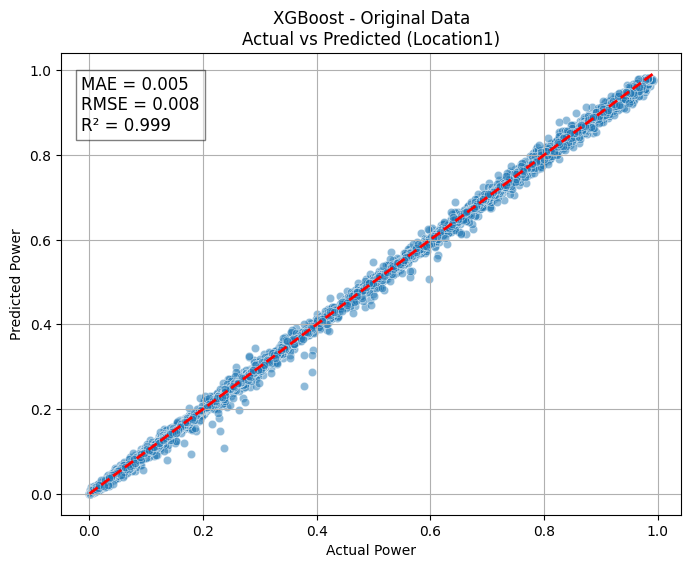

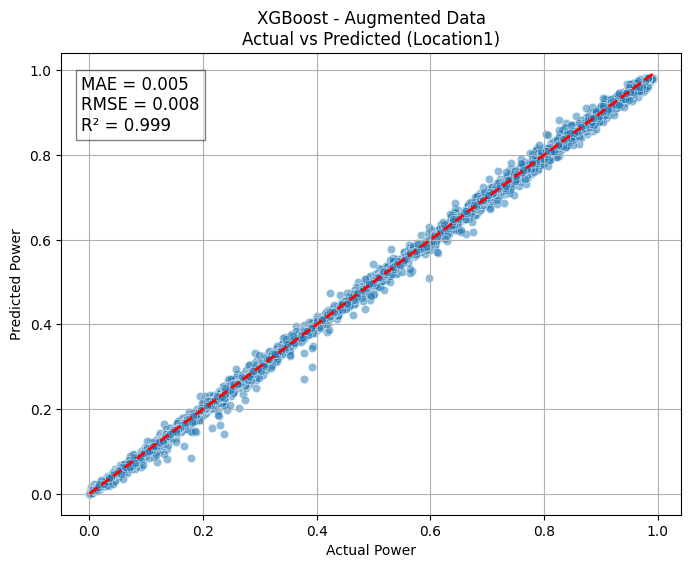

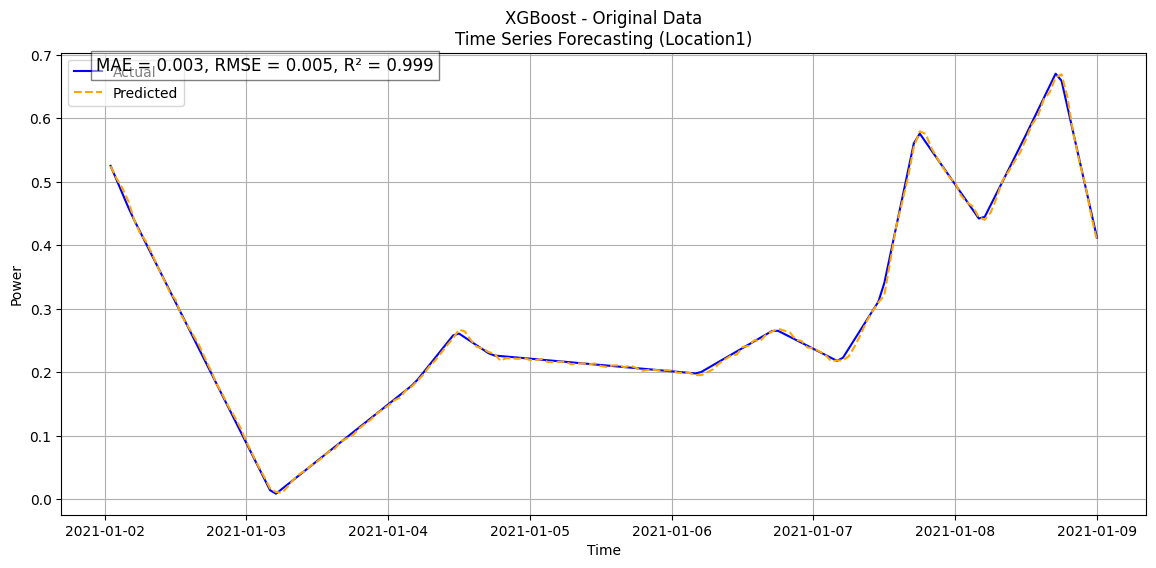

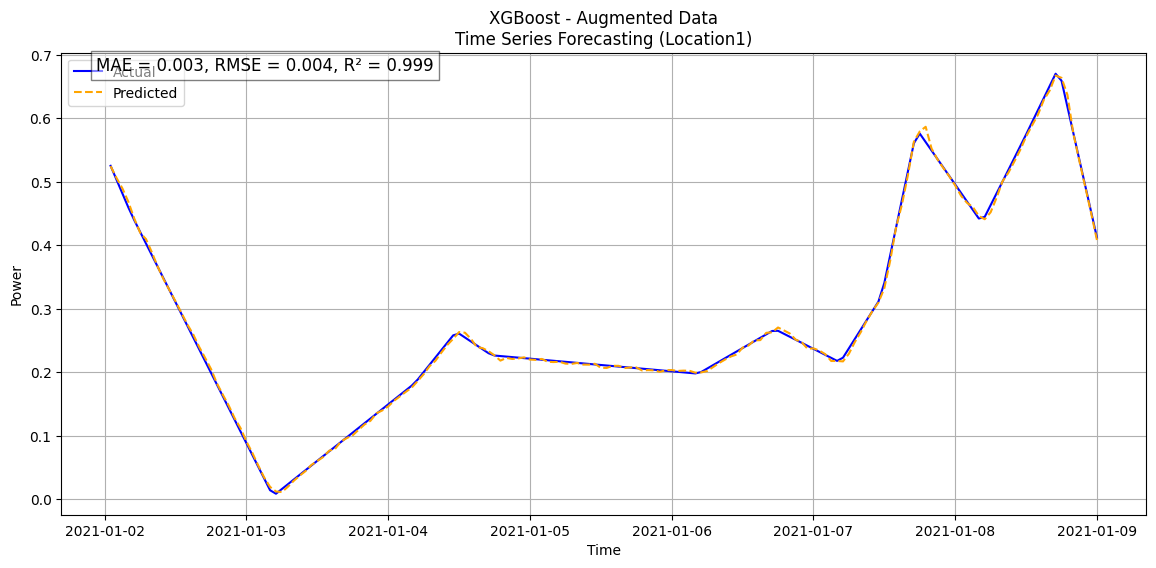

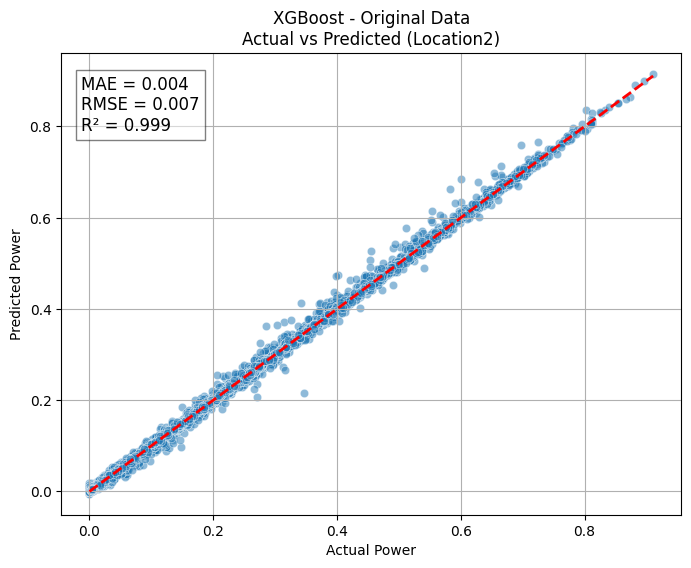

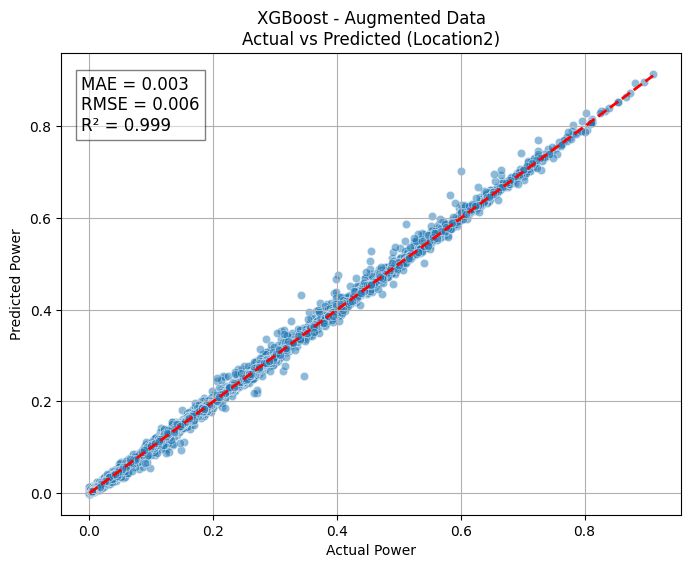

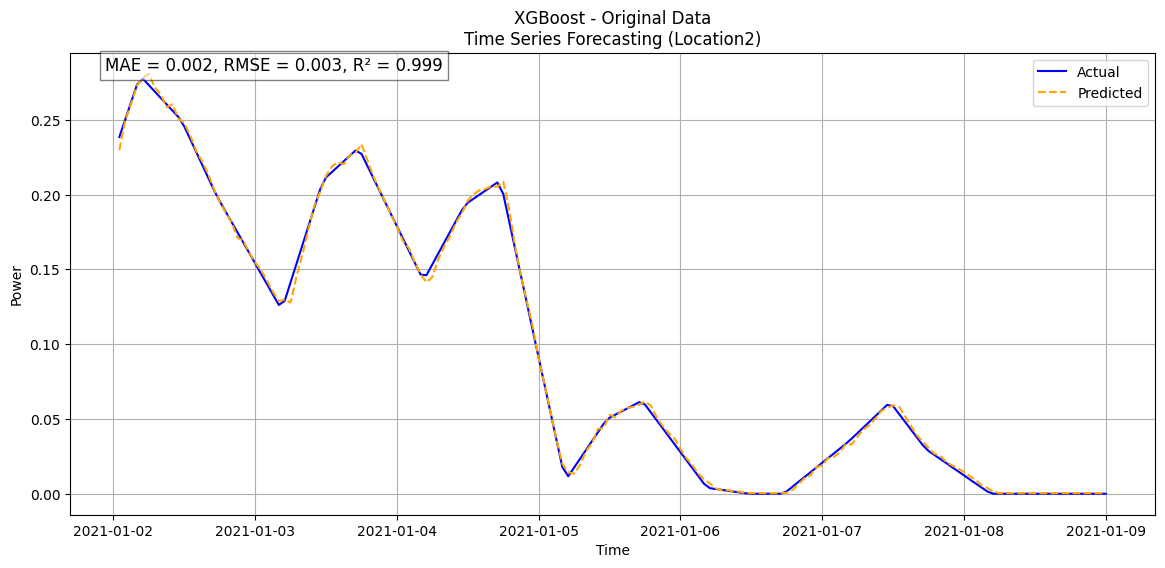

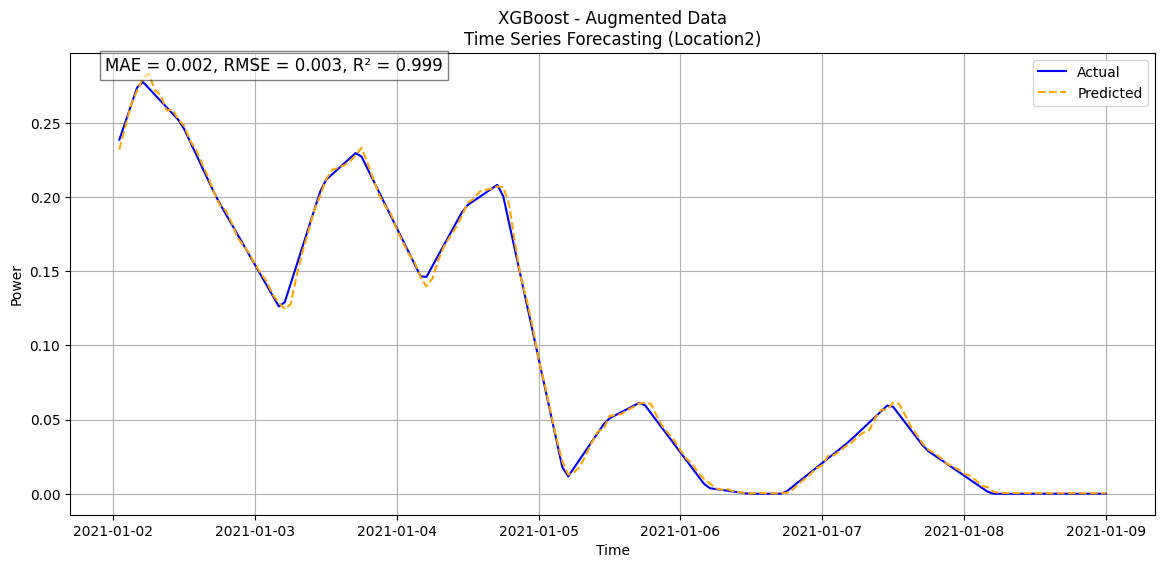

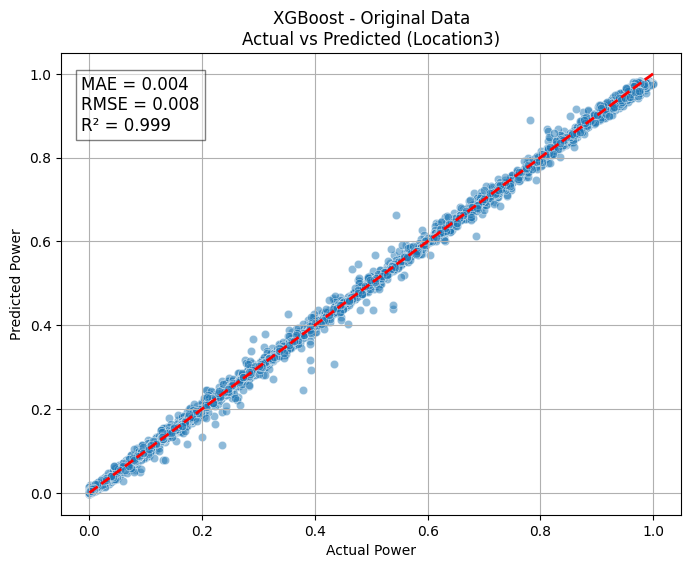

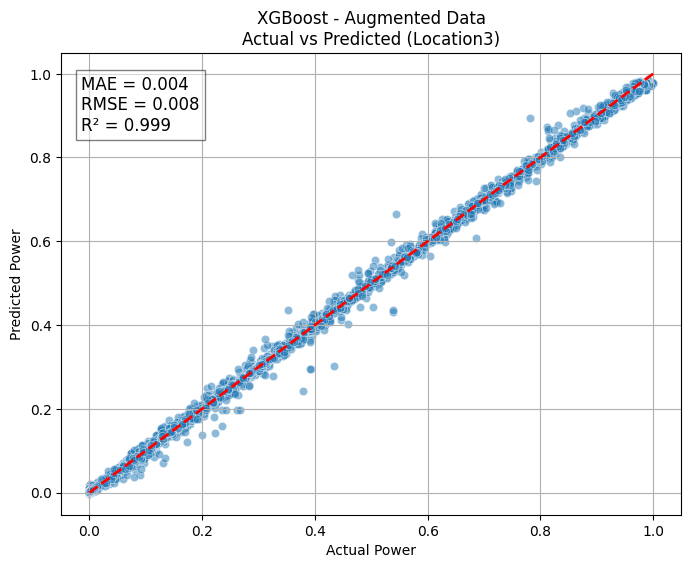

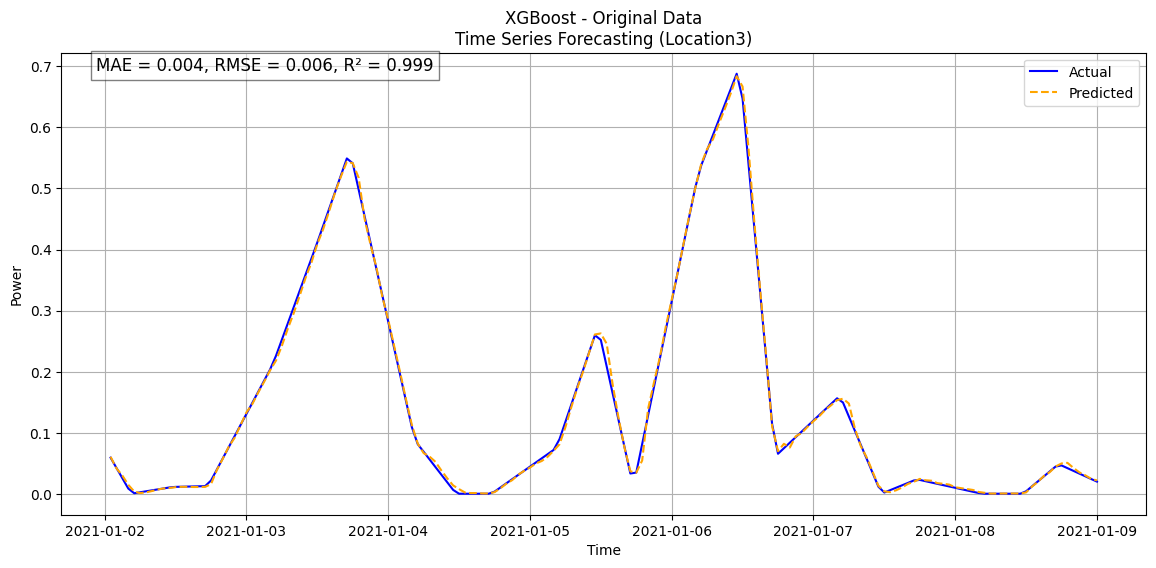

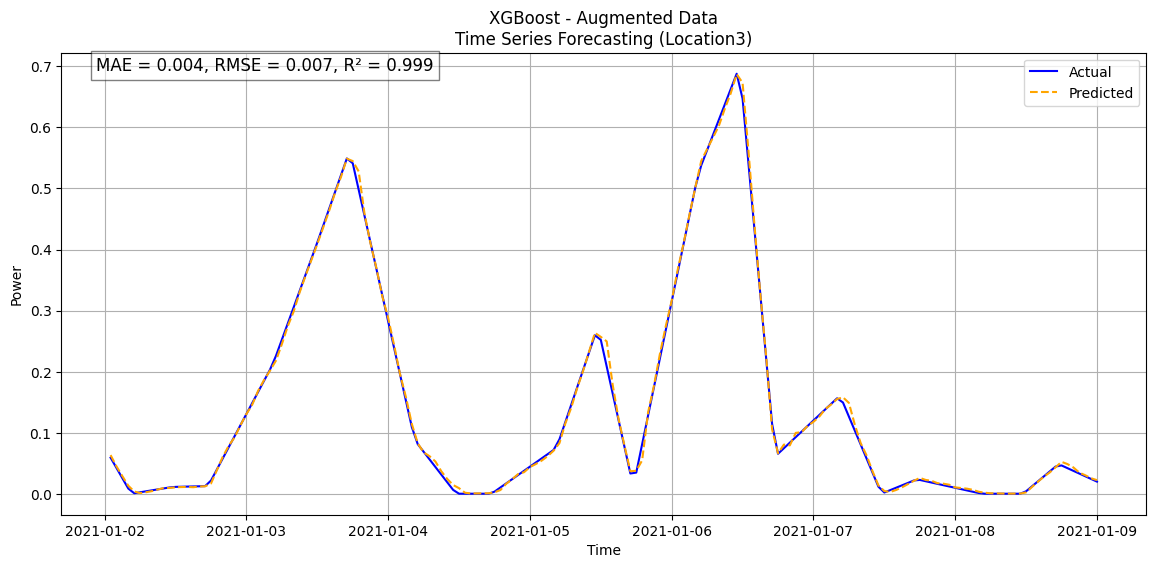

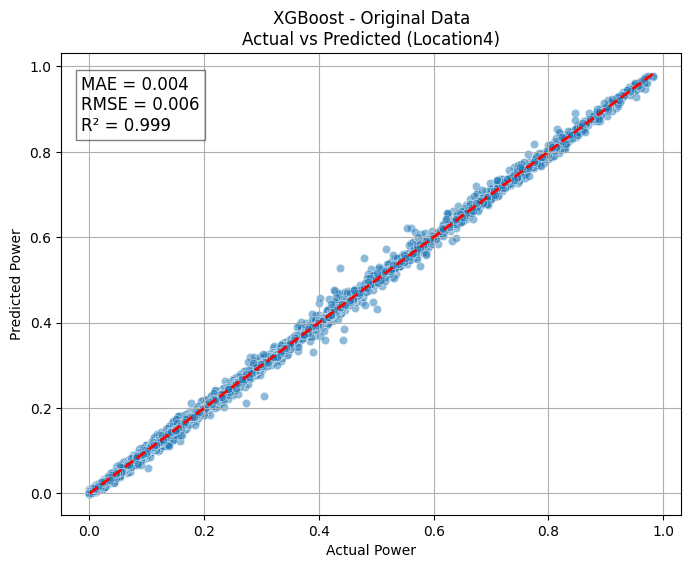

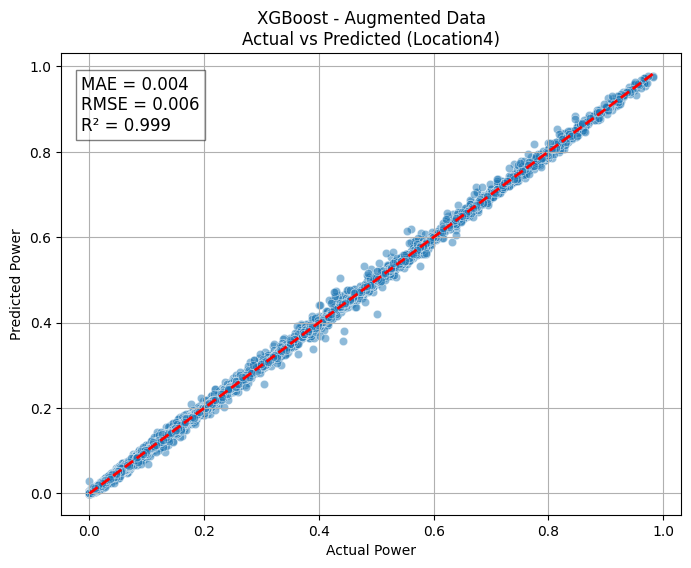

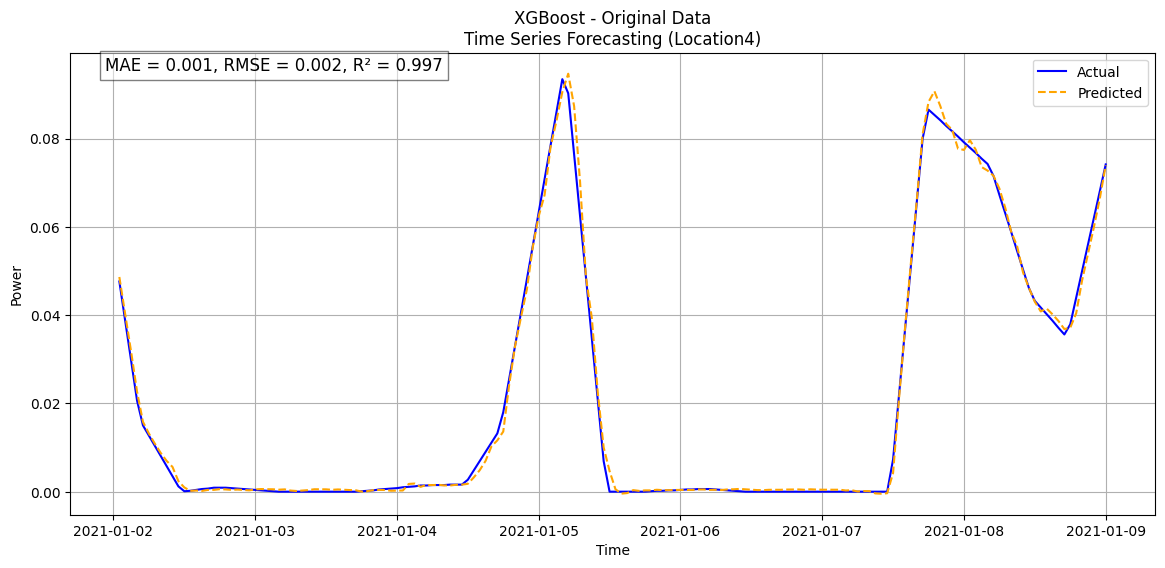

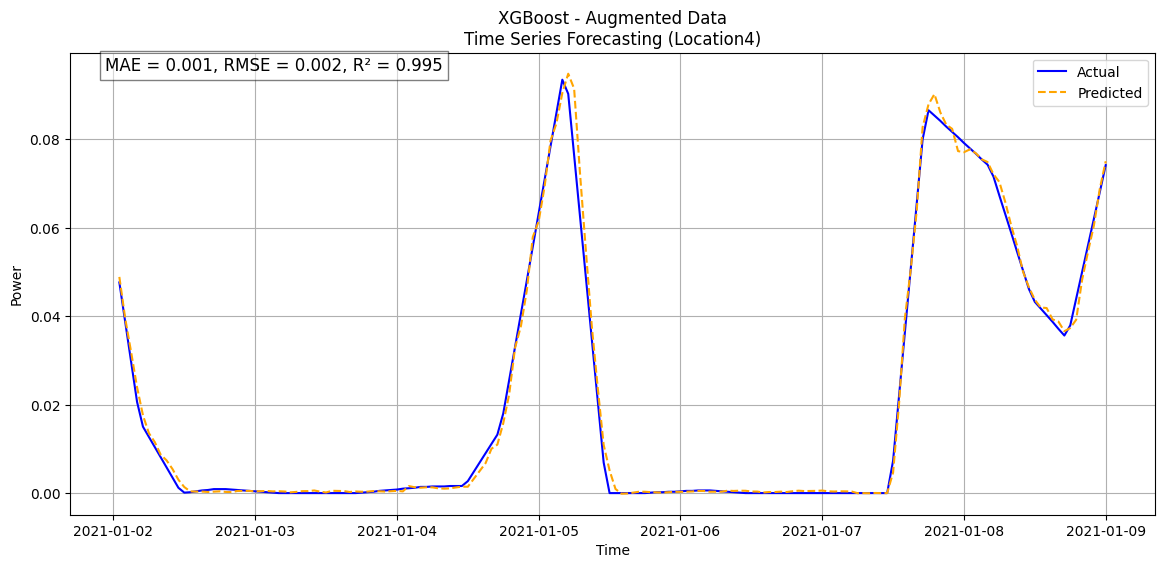

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========
# Functions
# =========

def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted ({location})')
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting ({location})')
    plt.legend()
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# =========
# Location-wise visualization
# =========

locations = org_test_processed['Location'].unique()

for loc in locations:
    # Extract data for this location
    loc_mask = org_test_processed['Location'] == loc
    X_test_loc = org_test_processed[features][loc_mask]
    y_test_loc = org_test_processed[target][loc_mask]
    timestamps_loc = org_test_processed['Timestamp'][loc_mask]
    
    # Predictions
    y_pred_org = xgb_org.predict(X_test_loc)
    y_pred_aug = xgb_aug.predict(X_test_loc)
    
    # Scatter plots
    plot_actual_vs_predicted(y_test_loc, y_pred_org, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_actual_vs_predicted(y_test_loc, y_pred_aug, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
    
    # Time series plots (only small subset for clarity)
    subset_size = 7*4*6  # 1 week if data hourly (adjust if needed)
    subset_X = X_test_loc.iloc[:subset_size]
    subset_y = y_test_loc.iloc[:subset_size]
    subset_t = timestamps_loc.iloc[:subset_size]
    
    y_pred_org_subset = xgb_org.predict(subset_X)
    y_pred_aug_subset = xgb_aug.predict(subset_X)
    
    plot_timeseries(subset_y, y_pred_org_subset, subset_t, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_timeseries(subset_y, y_pred_aug_subset, subset_t, model_name='XGBoost', dataset_name='Augmented Data', location=loc)


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_dual_forecast_split(timestamps, y_train, y_true, y_pred_org, y_pred_aug,
                              model_name='XGBoost', location='Unknown',
                              conf_int_org=None, conf_int_aug=None):
    """
    Plot actual values with forecasts from original and augmented models, including non-overlapping legend & metrics.
    """
    plt.figure(figsize=(14, 6))
    
    forecast_start_idx = len(y_train)
    full_timestamps = timestamps
    all_actual = np.concatenate([y_train, y_true])
    
    # Training
    plt.plot(full_timestamps[:forecast_start_idx], y_train, color='gray', label='Actual')
    
    # Observed
    plt.plot(full_timestamps[forecast_start_idx:], y_true, color='black', label='Observed')

    # Original Forecast
    plt.plot(full_timestamps[forecast_start_idx:], y_pred_org, color='red', label='Forecast (Original)')
    if conf_int_org:
        lower_o, upper_o = conf_int_org
        plt.fill_between(full_timestamps[forecast_start_idx:], lower_o, upper_o, color='red', alpha=0.2)

    # Augmented Forecast
    plt.plot(full_timestamps[forecast_start_idx:], y_pred_aug, color='blue', linestyle='--', label='Forecast (Augmented)')
    if conf_int_aug:
        lower_a, upper_a = conf_int_aug
        plt.fill_between(full_timestamps[forecast_start_idx:], lower_a, upper_a, color='blue', alpha=0.2)

    # Vertical forecast start line
    plt.axvline(full_timestamps[forecast_start_idx], color='gray', linestyle=':', linewidth=1)

    # Metrics
    mae_org = mean_absolute_error(y_true, y_pred_org)
    rmse_org = np.sqrt(mean_squared_error(y_true, y_pred_org))

    mae_aug = mean_absolute_error(y_true, y_pred_aug)
    rmse_aug = np.sqrt(mean_squared_error(y_true, y_pred_aug))

    # Display metrics bottom-left
    error_text = (
        f"Original:  MAE = {mae_org:.4f}, RMSE = {rmse_org:.4f}\n"
        f"Augmented: MAE = {mae_aug:.4f}, RMSE = {rmse_aug:.4f}"
    )
    plt.gcf().text(0.02, 0.02, error_text, fontsize=11,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    # Labels and legend
    plt.title(f"{model_name} Forecast Comparison - {location}")
    plt.xlabel("Date")
    plt.ylabel("Power / Demand")
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


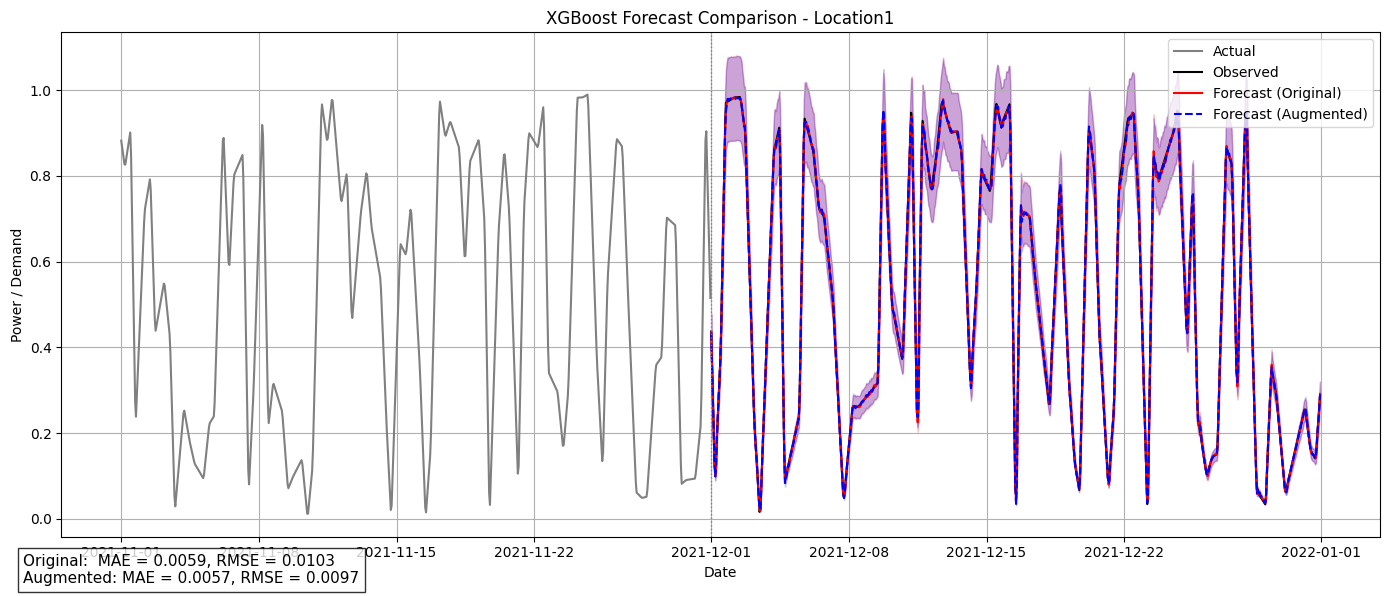

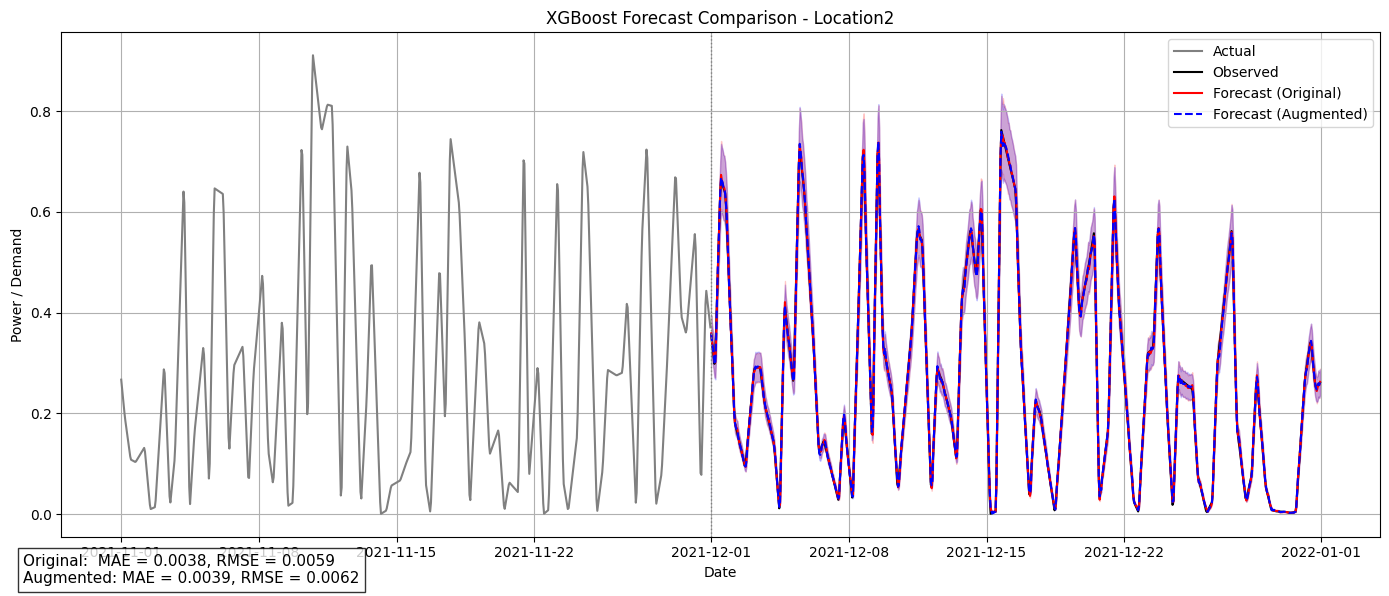

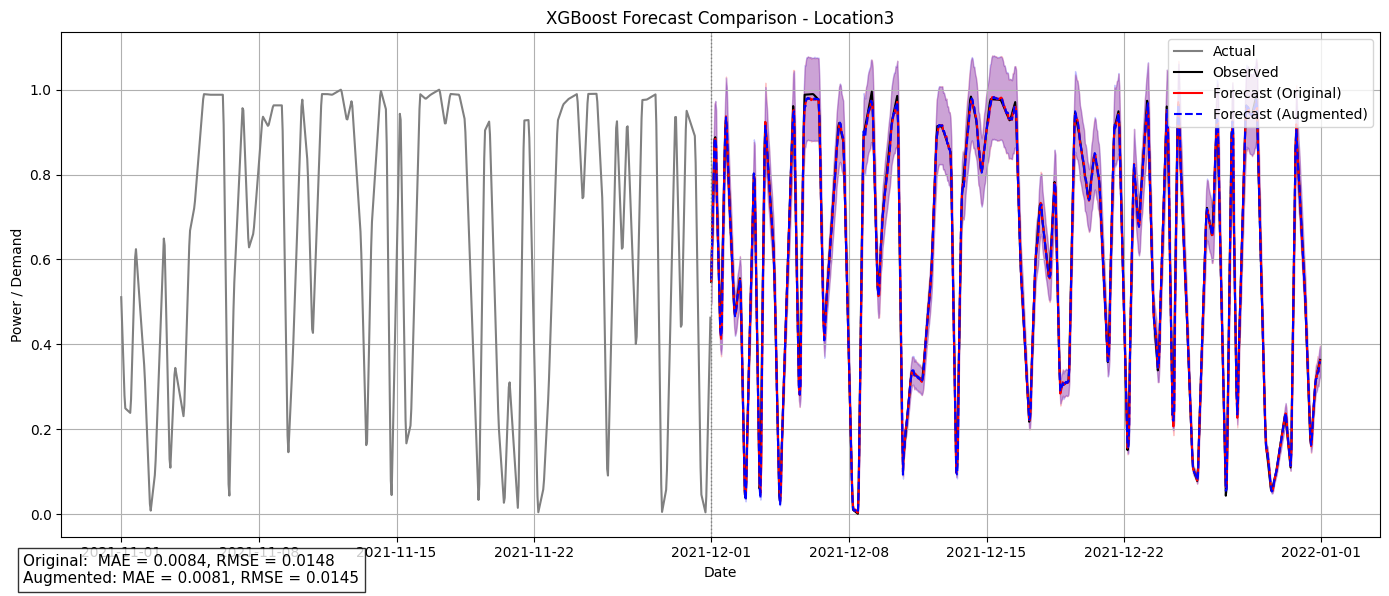

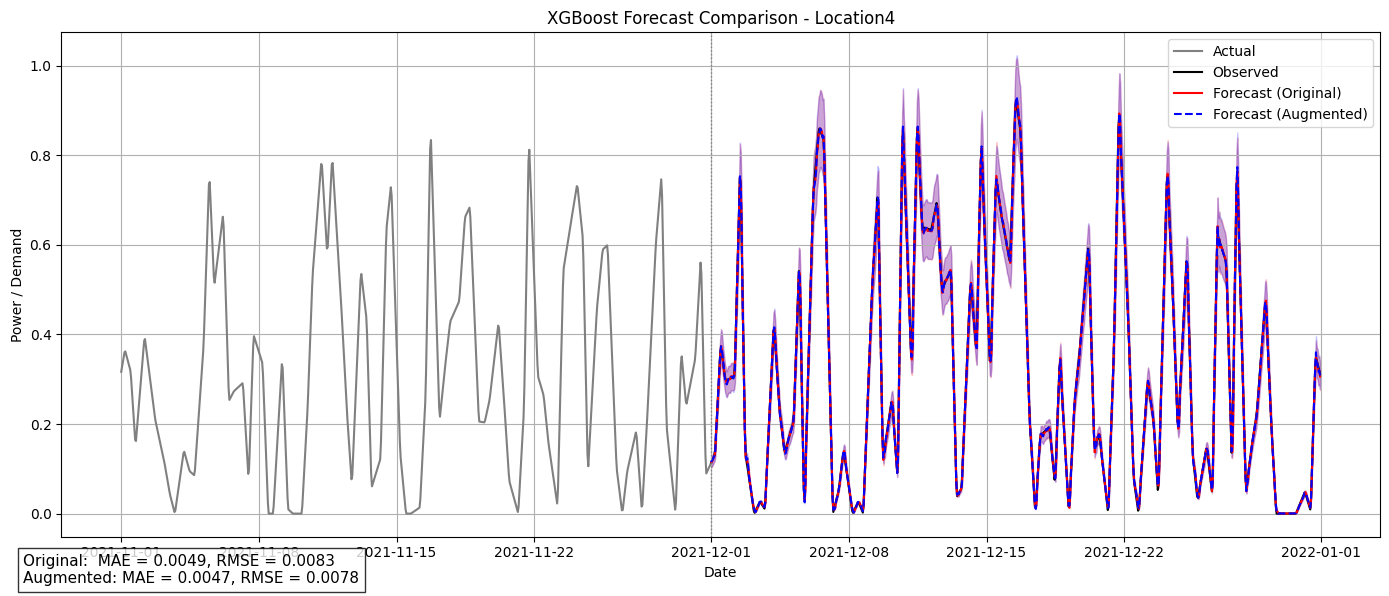

In [29]:
for loc in locations:
    loc_data = org_test_processed[org_test_processed['Location'] == loc].copy()
    loc_data.sort_values('Timestamp', inplace=True)
    loc_data['Timestamp'] = pd.to_datetime(loc_data['Timestamp'])
    loc_data['YearMonth'] = loc_data['Timestamp'].dt.to_period('M')

    # Pick a training month and the next one for forecast
    available_months = sorted(loc_data['YearMonth'].unique())
    
    if len(available_months) < 2:
        continue  # Not enough data to plot

    train_month = available_months[-2]  # e.g., August
    forecast_month = available_months[-1]  # e.g., September

    train_data = loc_data[loc_data['YearMonth'] == train_month]
    forecast_data = loc_data[loc_data['YearMonth'] == forecast_month]

    X_train = train_data[features]
    y_train = train_data[target]

    X_forecast = forecast_data[features]
    y_forecast_true = forecast_data[target]

    # Timestamps
    full_timestamps = np.concatenate([train_data['Timestamp'].values, forecast_data['Timestamp'].values])

    # Forecasts
    y_pred_org = xgb_org.predict(X_forecast)
    y_pred_aug = xgb_aug.predict(X_forecast)

    # Confidence intervals (dummy)
    ci_org = (y_pred_org * 0.9, y_pred_org * 1.1)
    ci_aug = (y_pred_aug * 0.9, y_pred_aug * 1.1)

    # Plot
    plot_dual_forecast_split(
        timestamps=full_timestamps,
        y_train=y_train,
        y_true=y_forecast_true,
        y_pred_org=y_pred_org,
        y_pred_aug=y_pred_aug,
        model_name='XGBoost',
        location=loc,
        conf_int_org=ci_org,
        conf_int_aug=ci_aug
    )


In [30]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan  # All true values are zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100

def evaluate_monthly_timesnet_errors(
    model_org, model_aug,
    X_test, y_test,

):
    # Ensure datetime index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    
    n_locations = 4
    loc_size = len(X_test) // n_locations
    results = []

    for loc in range(n_locations):
        start, end = loc * loc_size, (loc + 1) * loc_size
        X_loc = X_test[start:end]
        y_loc = y_test[start:end]
        time_loc = X_test.index[start:end]

        df_loc = pd.DataFrame(X_loc, index=time_loc)
        df_loc['target'] = y_loc

        for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
            

            X_month = df_month.drop(columns='target').values
            merged_true = df_month['target'].values

            merged_pred_org = model_org.predict(X_month)
            
            merged_pred_aug = model_aug.predict(X_test)

            min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
            merged_pred_org = merged_pred_org[:min_len]
            merged_pred_aug = merged_pred_aug[:min_len]
            merged_true = merged_true[:min_len]

            # --- Metrics ---
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_org': mean_absolute_error(merged_true, merged_pred_org),
                'rmse_org': math.sqrt(mean_squared_error(merged_true, merged_pred_org)),
                'mape_org': mape(merged_true, merged_pred_org),
                'smape_org': smape(merged_true, merged_pred_org),
                'r2_org': r2_score(merged_true, merged_pred_org),
                'mae_aug': mean_absolute_error(merged_true, merged_pred_aug),
                'rmse_aug': math.sqrt(mean_squared_error(merged_true, merged_pred_aug)),
                'mape_aug': mape(merged_true, merged_pred_aug),
                'smape_aug': smape(merged_true, merged_pred_aug),
                'r2_aug': r2_score(merged_true, merged_pred_aug),
            })

    results_df = pd.DataFrame(results)

    # Monthly summary across all locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_org': ['mean', 'std'],
        'rmse_org': ['mean', 'std'],
        'mape_org': ['mean', 'std'],
        'smape_org': ['mean', 'std'],
        'r2_org': ['mean', 'std'],
        'mae_aug': ['mean', 'std'],
        'rmse_aug': ['mean', 'std'],
        'mape_aug': ['mean', 'std'],
        'smape_aug': ['mean', 'std'],
        'r2_aug': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]
    return results_df, monthly_summary


In [31]:
results_df, monthly_summary = evaluate_monthly_timesnet_errors(
    model_org=xgb_org,
    model_aug=xgb_aug,
    X_test=X_test,
    y_test=y_test,
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4723/839829463.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4723/839829463.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4723/839829463.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4723/839829463.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):


In [32]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_org': f"{loc_data['mae_org'].mean():.4f}  ± {loc_data['mae_org'].std():.4f}",
        'rmse_org': f"{loc_data['rmse_org'].mean():.4f}  ± {loc_data['rmse_org'].std():.4f}",
        'mape_org': f"{loc_data['mape_org'].mean():.4f}  ± {loc_data['mape_org'].std():.4f}",
        'smape_org': f"{loc_data['smape_org'].mean():.4f}  ± {loc_data['smape_org'].std():.4f}",
        'r2_org': f"{loc_data['r2_org'].mean():.4f}  ± {loc_data['r2_org'].std():.4f}",
        'mae_aug': f"{loc_data['mae_aug'].mean():.4f}  ± {loc_data['mae_aug'].std():.4f}",
        'rmse_aug': f"{loc_data['rmse_aug'].mean():.4f}  ± {loc_data['rmse_aug'].std():.4f}",
        'mape_aug': f"{loc_data['mape_aug'].mean():.4f}  ± {loc_data['mape_aug'].std():.4f}",
        'smape_aug': f"{loc_data['smape_aug'].mean():.4f}  ± {loc_data['smape_aug'].std():.4f}",
        'r2_aug': f"{loc_data['r2_aug'].mean():.4f}  ± {loc_data['r2_aug'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_org': f"{results_df['mae_org'].mean():.4f}  ± {results_df['mae_org'].std():.4f}",
    'rmse_org': f"{results_df['rmse_org'].mean():.4f}  ± {results_df['rmse_org'].std():.4f}",
    'mape_org': f"{results_df['mape_org'].mean():.4f}  ± {results_df['mape_org'].std():.4f}",
    'smape_org': f"{results_df['smape_org'].mean():.4f}  ± {results_df['smape_org'].std():.4f}",
    'r2_org': f"{results_df['r2_org'].mean():.4f}  ± {results_df['r2_org'].std():.4f}",
    'mae_aug': f"{results_df['mae_aug'].mean():.4f}  ± {results_df['mae_aug'].std():.4f}",
    'rmse_aug': f"{results_df['rmse_aug'].mean():.4f}  ± {results_df['rmse_aug'].std():.4f}",
    'mape_aug': f"{results_df['mape_aug'].mean():.4f}  ± {results_df['mape_aug'].std():.4f}",
    'smape_aug': f"{results_df['smape_aug'].mean():.4f}  ± {results_df['smape_aug'].std():.4f}",
    'r2_aug': f"{results_df['r2_aug'].mean():.4f}  ± {results_df['r2_aug'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [33]:
final_results

,Location,mae_org,rmse_org,mape_org,smape_org,r2_org,mae_aug,rmse_aug,mape_aug,smape_aug,r2_aug
0,Location_1,0.0048 ± 0.0008,0.0078 ± 0.0016,4.2448 ± 3.9791,3.4203 ± 2.4353,0.9992 ± 0.0003,0.3119 ± 0.1059,0.3803 ± 0.1251,1453.8045 ± 2764.7113,83.3837 ± 28.3784,-1.2118 ± 1.1323
1,Location_2,0.0035 ± 0.0008,0.0064 ± 0.0017,9.7928 ± 3.5587,23.2671 ± 24.5490,0.9985 ± 0.0004,0.3178 ± 0.0185,0.4017 ± 0.0212,1908.7430 ± 997.1500,111.9824 ± 19.0417,-5.7570 ± 3.3281
2,Location_3,0.0041 ± 0.0023,0.0071 ± 0.0036,16.6597 ± 15.1147,41.3163 ± 37.7315,0.9978 ± 0.0016,0.3409 ± 0.0472,0.4277 ± 0.0559,5413.1052 ± 7241.2460,119.5170 ± 30.6250,-47.7802 ± 133.1854
3,Location_4,0.0038 ± 0.0006,0.0063 ± 0.0011,8.2639 ± 3.5906,11.3356 ± 5.3622,0.9988 ± 0.0007,0.3040 ± 0.0278,0.3843 ± 0.0340,1794.1749 ± 1622.8553,101.0056 ± 10.6711,-3.6025 ± 3.8052
4,All Location Combined,0.0041 ± 0.0014,0.0069 ± 0.0022,9.7403 ± 9.1459,19.8348 ± 26.2759,0.9986 ± 0.0010,0.3186 ± 0.0600,0.3985 ± 0.0716,2642.4569 ± 4189.5191,103.9722 ± 26.6092,-14.5879 ± 67.3462


In [34]:
monthly_summary

,month,mae_org_mean,mae_org_std,rmse_org_mean,rmse_org_std,mape_org_mean,mape_org_std,smape_org_mean,smape_org_std,r2_org_mean,...,mae_aug_mean,mae_aug_std,rmse_aug_mean,rmse_aug_std,mape_aug_mean,mape_aug_std,smape_aug_mean,smape_aug_std,r2_aug_mean,r2_aug_std
0,2021-01,0.003414,0.000961,0.005733,0.001834,14.538313,11.624323,25.596722,18.487927,0.999095,...,0.234932,0.156750,0.300317,0.199255,5056.873843,5559.050212,90.576318,59.414517,-4.033403,6.065001
1,2021-02,0.003721,0.001059,0.006347,0.001252,15.956057,17.987599,25.987123,26.381441,0.998847,...,0.327932,0.051710,0.405806,0.051909,1490.288590,1575.012668,110.424939,22.782116,-4.460932,4.094244
2,2021-03,0.004098,0.001558,0.007164,0.002888,16.823775,20.192147,18.057972,16.973220,0.998959,...,0.338204,0.018430,0.417707,0.018439,6543.624859,10485.694881,108.158624,22.926933,-3.790980,3.413508
3,2021-04,0.004523,0.000690,0.008181,0.000803,5.921965,3.548013,16.657668,20.353198,0.998174,...,0.304076,0.008268,0.387864,0.006854,1495.911658,1333.750778,96.567190,16.615759,-3.096065,1.598162
4,2021-05,0.003682,0.000929,0.006301,0.001198,8.582979,5.630688,21.369104,26.214566,0.998606,...,0.299540,0.040749,0.382082,0.053839,4816.164799,6903.399554,102.425966,25.037239,-6.867648,9.591330
5,2021-06,0.003149,0.000943,0.005377,0.001012,10.769476,5.406548,42.160713,39.580320,0.998403,...,0.328085,0.032213,0.420239,0.036005,2518.691798,2077.810077,121.657236,34.430864,-13.546288,19.576012
6,2021-07,0.002801,0.001276,0.004949,0.002079,8.961423,7.280691,39.474521,64.278457,0.997159,...,0.356173,0.038372,0.443787,0.041228,1691.878941,1393.376377,126.676825,38.033272,-123.023949,230.598161
7,2021-08,0.003425,0.000690,0.005890,0.001198,11.878140,2.734006,21.253702,20.411453,0.998325,...,0.344098,0.020985,0.428994,0.015971,3565.254617,2374.917524,120.327111,10.164543,-8.887221,6.722253
8,2021-09,0.004059,0.000411,0.006700,0.000474,6.270591,2.120464,7.479890,3.196961,0.998929,...,0.280732,0.033883,0.353978,0.043305,1122.206087,939.058163,94.140258,10.275756,-2.268239,1.997898
9,2021-10,0.004348,0.001001,0.007245,0.001840,8.898255,4.085582,10.214391,3.670246,0.999198,...,0.315223,0.028334,0.392479,0.032368,2599.155121,3532.726883,99.316849,8.480385,-1.512348,1.201893


In [35]:
FOLDER_NAME = './Results/XGB'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)